In [ ]:
import pandas as pd
import datetime as dt

# Introducción

El objetivo de este documento es el de explorar la **segmentación de clientes por valor**. Esta herramienta permite identificar a los clientes que aportan los mayores inresos para una empresa, los cuales representan un segmento valioso que exige la mayor atención.

Para realizar la segmentación, utilizaremos las siguientes métricas: **recencia, frecuencia y valor monetario**. 

Recencia: Numero de dias que han transcurrido sin realizar compras un cliente.

Los datos que utilizaremos fueron obtenidos de la siguiente página: 

https://www.kaggle.com/code/regivm/rfm-analysis-tutorial/data

# Lectura y exploración de datos

In [ ]:
df = pd.read_csv("rfm.csv")
df['trans_date'] = pd.to_datetime(df['trans_date']) 
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


La tabla cuenta con 125,000 registros, que identifican a cada transacción, de cada cliente [de alguna empresa] y el valor monetario de la transacción. 

In [ ]:
df.describe() #125,000 registros 

,tran_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


Las transacciones corresponden a 6889 clientes diferentes:

In [ ]:
len(df['customer_id'].unique()) #6889 clientes

6889

El registro abarca transacciones realizadas entre el 16 de mayo de 2011 y el 16 de marzo de 2015. 

In [ ]:
min(df['trans_date'])

Timestamp('2011-05-16 00:00:00')

In [ ]:
max(df['trans_date'])

Timestamp('2015-03-16 00:00:00')

## Serie de tiempo [ingresos diarios] 

La siguiente gráfica muestra el total obtenido por las transacciones diarias:

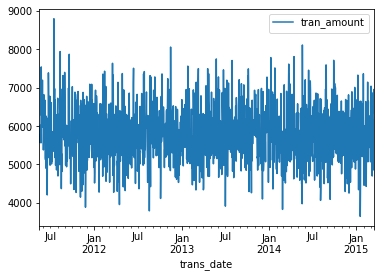

In [ ]:
trans_daily = df.groupby("trans_date").sum() #agrupamos las transacciones por día
trans_daily.plot()

Suavicemos la serie [promedio móvil mensual]

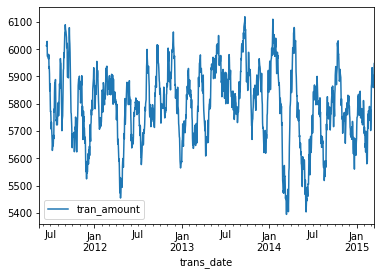

In [ ]:
trans_daily.rolling(30).mean().plot()

# Valor monetario

Exploremos la utilización del valor monetario como métrica para basar la segmentación de clientes:

In [ ]:
cust_amount = df.groupby("customer_id")['tran_amount'].sum()
cust_amount[:10]

customer_id
CS1112    1012
CS1113    1490
CS1114    1432
CS1115    1659
CS1116     857
CS1117    1185
CS1118    1011
CS1119    1158
CS1120    1677
CS1121    1524
Name: tran_amount, dtype: int64

Identificamos los 10 clientes con mayor valor monetario.

In [ ]:
cust_amount.sort_values(ascending=False)[:10]

customer_id
CS4424    2933
CS4320    2647
CS5752    2612
CS4660    2527
CS3799    2513
CS5109    2506
CS4074    2462
CS3805    2453
CS4608    2449
CS5555    2439
Name: tran_amount, dtype: int64

Gráficamente

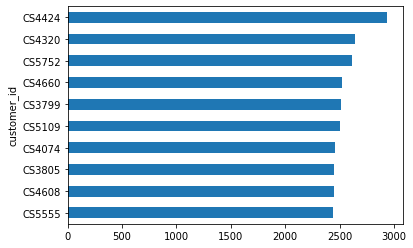

In [ ]:
ax = cust_amount.sort_values(ascending=False)[:10].plot.barh()
ax.invert_yaxis()

Distribución del valor monetario:

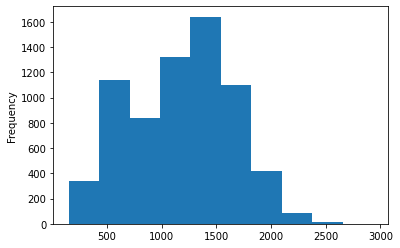

In [ ]:
cust_amount.plot.hist()

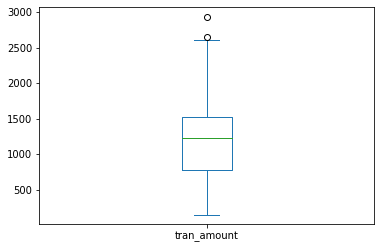

In [ ]:
cust_amount.plot.box()

# Segmentación por valor [quintiles]

Usemos el valor monetario para agrupar a los clientes (usando los quintiles de tal variable)

In [ ]:
# evaluamos los quintiles del valor monetario
cust_amount.quantile([0.2*(i+1) for i in range(5)])

0.2     681.0
0.4    1095.0
0.6    1345.0
0.8    1589.0
1.0    2933.0
Name: tran_amount, dtype: float64

In [ ]:
customer_segmentation = pd.qcut(cust_amount, 5, labels=["q1", "q2", "q3", "q4", "q5"])
customer_segmentation[:10]

customer_id
CS1112    q2
CS1113    q4
CS1114    q4
CS1115    q5
CS1116    q2
CS1117    q3
CS1118    q2
CS1119    q3
CS1120    q5
CS1121    q4
Name: tran_amount, dtype: category
Categories (5, object): ['q1' < 'q2' < 'q3' < 'q4' < 'q5']

In [ ]:
cust_val = pd.DataFrame({'val': cust_amount, 'quintil': customer_segmentation})
cust_val.head()

,val,quintil
customer_id,,
CS1112,1012,q2
CS1113,1490,q4
CS1114,1432,q4
CS1115,1659,q5
CS1116,857,q2


# Otras métricas

Utilizar únicamente el valor monetario como métrica para segmentar 
Utilicemos otras métricas para realziar la segmentación por valor:

* **Recencia**: cuánto tiempo ha pasado desde la última compra. 
* **Frecuencia**: número total de compras (eventos). 
* **Valor monetario**: monto total de las compras del cliente. 

## Ventana de tiempo

Limitemos el análisis a los datos generados en el año más reciente:

In [ ]:
max(df['trans_date'])

Timestamp('2015-03-16 00:00:00')

In [ ]:
df_last_year = df[df["trans_date"]>"2014-03-16"]
df_last_year.head()

,customer_id,trans_date,tran_amount
1,CS4768,2015-03-15,39
5,CS5539,2014-03-26,81
7,CS5902,2015-01-30,89
14,CS5552,2014-12-29,78
18,CS3904,2014-07-20,103


In [ ]:
df_last_year.describe()

,tran_amount
count,32328.000000
mean,65.066196
std,22.961195
min,10.000000
25%,47.000000
50%,65.000000
75%,84.000000
max,105.000000


**Recencia**

¿Cuánto tiempo ha pasado entre la *fecha actual* y la de la compra más reciente del cliente? 

In [ ]:
fecha_final = dt.datetime(2015,3,17) # fecha "actual"

df_last_year['tiempo_trans'] = (fecha_final - df_last_year['trans_date'])/pd.to_timedelta(1, unit='D')
df_last_year.head()

<ipython-input-351-83f89f63f282>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_year['tiempo_trans'] = (fecha_final - df_last_year['trans_date'])/pd.to_timedelta(1, unit='D')


,customer_id,trans_date,tran_amount,tiempo_trans
1,CS4768,2015-03-15,39,2.0
5,CS5539,2014-03-26,81,356.0
7,CS5902,2015-01-30,89,46.0
14,CS5552,2014-12-29,78,78.0
18,CS3904,2014-07-20,103,240.0


Para encontrar la recencia, agrupemos por cliente y encontremos el mínimo tiempo transcurrido.

In [ ]:
recencia = df_last_year.groupby("customer_id")['tiempo_trans'].min()
recencia[:10]

customer_id
CS1112     62.0
CS1113     36.0
CS1114     33.0
CS1115     12.0
CS1116    204.0
CS1117    258.0
CS1118      3.0
CS1119     12.0
CS1120     11.0
CS1121     42.0
Name: tiempo_trans, dtype: float64

**Frecuencia**

¿Cuántas compras realizó el cliente en el periodo de interés?

In [ ]:
frecuencia = df_last_year.groupby("customer_id").size()
frecuencia[:10]

customer_id
CS1112    4
CS1113    6
CS1114    5
CS1115    3
CS1116    4
CS1117    3
CS1118    6
CS1119    5
CS1120    7
CS1121    5
dtype: int64

**Valor monetario**

¿Cuál el ingreso obtenido por cada cliente en el periodo de interés?

In [ ]:
val_monet = df_last_year.groupby("customer_id")['tran_amount'].sum()
val_monet[:10]

customer_id
CS1112    251
CS1113    393
CS1114    315
CS1115    248
CS1116    286
CS1117    216
CS1118    431
CS1119    339
CS1120    407
CS1121    241
Name: tran_amount, dtype: int64

Formamos la tabla de recencia, frecuencia, valor monetario:

In [ ]:
rfm = pd.DataFrame({'rec': recencia, "frec": frecuencia, "val_mon": val_monet})
rfm.head()

,rec,frec,val_mon
customer_id,,,
CS1112,62.0,4,251
CS1113,36.0,6,393
CS1114,33.0,5,315
CS1115,12.0,3,248
CS1116,204.0,4,286


In [ ]:
rfm.describe()

,rec,frec,val_mon
count,6781.000000,6781.000000,6781.000000
mean,75.546969,4.767438,310.199086
std,70.425888,2.206930,172.799880
min,1.000000,1.000000,10.000000
25%,22.000000,3.000000,176.000000
50%,53.000000,5.000000,290.000000
75%,108.000000,6.000000,423.000000
max,364.000000,14.000000,1019.000000


Guardamos los datos.

In [ ]:
rfm.to_csv("rfm_data_seg.csv")

<font color="red">Práctica</font>

El objetivo de esta práctica es segmentar los clientes considerando las 3 métricas: recencia, frecuencia y valor monetario.

* Estandariza las variables para evitar problemas de escala.
* Aplica alguna técnica de agrupamiento de datos (k-medias, clustering jerárquico, ...) sobre el conjunto de datos.
* Determina, mediante alguna estrategia o métrica adecuada, el total de grupos que considerarás en la segmentación.   


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

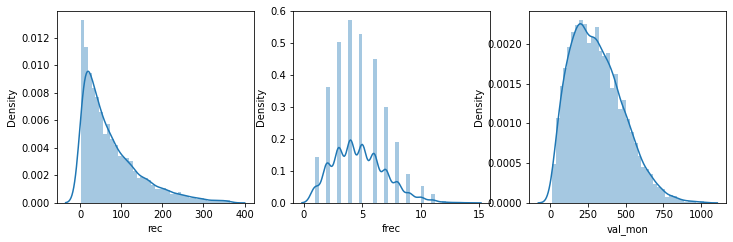

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
for i, column in enumerate(rfm.columns, 1):
  plt.subplot(3,3,i)
  sns.distplot(rfm[column])

In [ ]:
from sklearn.preprocessing import StandardScaler

object = StandardScaler()
scale = object.fit_transform(rfm)

rfm_norm = pd.DataFrame(scale, columns=['rec','frec','val_mon'])
rfm_norm

,rec,frec,val_mon
0,-0.192372,-0.347766,-0.342613
1,-0.561582,0.558537,0.479208
2,-0.604183,0.105386,0.027785
3,-0.902391,-0.800918,-0.359975
4,1.824081,-0.347766,-0.140051
...,...,...,...
6776,0.318841,0.558537,0.149322
6777,2.647702,-1.707221,-1.534831
6778,0.134237,-0.347766,-1.042896
6779,2.590901,-1.254069,-1.552194


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

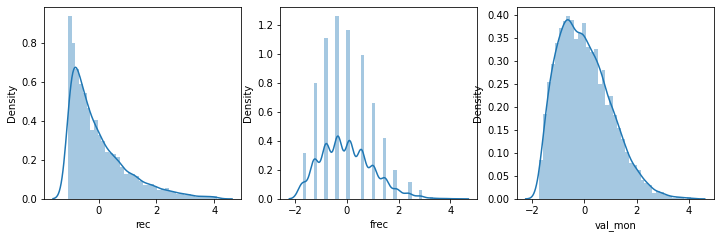

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
for i, column in enumerate(rfm_norm.columns, 1):
  plt.subplot(3,3,i)
  sns.distplot(rfm_norm[column])

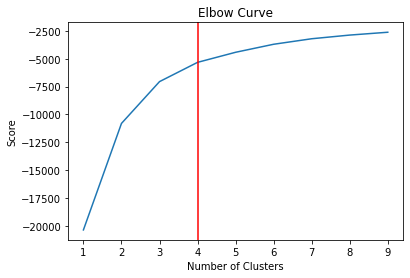

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(scale).score(scale) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.axvline(x=4, color = 'red')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
rfm_norm.quantile([0.25*(i+1) for i in range(4)])

,rec,frec,val_mon
0.25,-0.760387,-0.800918,-0.776673
0.50,-0.320175,0.105386,-0.116902
0.75,0.460845,0.558537,0.652832
1.00,4.096140,4.183750,4.102162


In [ ]:
rfm_segmentation = pd.qcut(rfm_norm.rec, 4, labels=["q1", "q2", "q3", "q4"])
rfm_segmentation[:10]

rfm_final = pd.DataFrame({'quartil': rfm_segmentation})
rfm_final = rfm_final.set_index(rfm.index)

In [ ]:
rfm_final.describe()

,quartil
count,6781
unique,4
top,q1
freq,1715


In [ ]:
rfm_final

,quartil
customer_id,
CS1112,q3
CS1113,q2
CS1114,q2
CS1115,q1
CS1116,q4
...,...
CS8996,q3
CS8997,q4
CS8998,q3
